<h1 style='color:orange; font-weight:bold; text-align:center'>Optimizing Ride Fares: A Dynamic Pricing Model for Ride-Sharing Services</h1>

## **1 Introduction**
### **1.1 Context**
Liat buku merah buat indicating centrality or importance of dynamic pricing in business. Why do we need dynamic pricing in the first place. 

### **1.2 Problem Statement**
Currently, ride fares are only determined by using ride duration, making it less profitable when the supply of bikes does not match its demand. The ride-sharing company is exploring how to set price in a dynamic environment, including considering supply and demand, to maintain profitability.

### **1.3 Objective**
To establish a pricing system that automatically adapts fares to dynamic factors so revenue can be maximized.
### **1.4 Metrics**
As the model is designed to optimize fares based on real-time conditions, a misprediction of the model can be either under or overestimation, particularly if excessive, of the fares, resulting in business impacts in relation to revenue, satisfaction, and reputation. On one hand, underestimation occurs when the model predicts fares lower than it should be, causing increased demand and missing out on potential revenue. On the other hand, overestimation can deter potential customers, and hence, leading to lower ride volume and reduced revenue. 
To simulate the financial impacts of the misprediction by the model, let us see the following hypothetical scenario using Divvy's data for an illustration purpose.
- **Underestimation of cost**: If the model underestimates the fare by USD0.50 on average, and there are 533K per month (average of 2022 ride data, [Chicago Tribune, 2024](https://www.chicagotribune.com/2023/06/30/divvy-bikes-hit-the-streets-of-chicago-10-years-ago-the-decade-has-been-filled-with-changes-and-challenges/#:~:text=Total%20Divvy%20rides%20each%20month%20from%202013%20to%202023&Trends%20show%20that%20ridership%20peaks,growth%20over%20the%20last%20decade.&And%20much%20of%20that%20growth,see%20ridership%20totals%20each%20year.)), it means the monthly revenue loss will be approximately USD266.5K.
- **Overestimation of cost**: If the regression model overprices customers, there will be reduction in bike-sharing demand since the high service cost can deter potential customers. If the model makes errors by 5% per month, there will be 26.65K customers who gets overpricing. When we multiply this number of customers with Divvy's daily pass at USD 18.10 ([Divvy, 2024](https://divvybikes.com/pricing)), it means the bike-ride sharing company will lose approximately USD 482.3K per month.

Based on these two conditions, the relevant metrics to evaluate machine learning model's predictions are R-squared ($R^2$), Mean Absolute Error, and Root Mean Squared Error.
- **Coefficient of determination** ($R^2$): It represents the proportion of variance in the target variable explained by the features. This ML metric provides a general overview of the model fit, helping us understand the explanatory power of the model.
$$R^2=1-\frac{\sum_i(y_i-\hat{y}_i)^2}{\sum_i(y_i-\bar{y})^2}$$
- **Mean Absolute Error** (MAE): It measures the average absolute difference between predicted ($\hat{y}_i$) and actual values ($y_i$), enabling us to evaluate the average magnitude of errors made by the model. The lower score of MAE indicates that the model is a better fit to the data.
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n|y_i - \hat{y}_i|$$
- **Root Mean Squared Error** (RMSE): It measures the average squared difference between predicted ($\hat{y}_i$) and actual prices ($y_i$). In its interpretation, the lower RMSE score of a model, the better the model fits to the data.
$$\text{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^1(y_i-\hat{y_1})^2}$$

### **1.5 Dataset**
The dataset was obtained from [Möbius](https://www.kaggle.com/datasets/arashnic/dynamic-pricing-dataset/data) on Kaggle. In general, the dataset contains 10 variables:
- `Number_of_Riders`: Number of customers who use the bike-sharing service (int)
- `Number_of_Drivers`: Available supply of drivers
- `Location_Category`: Geographical area where the ride is requested.
- `Customer_Loyalty_Status`: Membership type, e.g., silver or gold
- `Average_Ratings`: Average satisfaction score given by the customer
- `Time_of_Booking`: Time of the day when the ride is booked
- `Vehicle_Type`: Type of vehicle requested
- `Expected_Ride_Duration`: Estimated duration of the ride
- `Historical_Cost_of_Ride`: Previous cost


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, kstest, shapiro 
plt.style.use('ggplot')
import ptitprince as pt

## **2 Data Understanding**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### **2.1 General data overview**

In [3]:
# create function to inspect df
def inspect_dataframe(df):
    print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
    print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
    print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [69]:
# load dataset
df = pd.read_csv('../data/dynamic_pricing.csv')

# remove underscore in colnames
df.columns = df.columns.str.replace('_', '')

# inspect dataframe
inspect_dataframe(df)

The dataframe contains 1000 rows and 10 cols.
- 6 are numeric cols
- 4 are object cols


,ColumnName,Nrow,DataType,NAPct,DuplicatePct,UniqueValue,Sample
0,NumberofRiders,1000,int64,0.0,0.0,81,"[90, 58, 42, 89, 78, 59, 93, 62, 79, 86, 60, 2..."
1,NumberofDrivers,1000,int64,0.0,0.0,79,"[45, 39, 31, 28, 22, 35, 43, 14, 6, 17, 38, 8,..."
2,LocationCategory,1000,object,0.0,0.0,3,"[Urban, Suburban, Rural]"
3,CustomerLoyaltyStatus,1000,object,0.0,0.0,3,"[Silver, Regular, Gold]"
4,NumberofPastRides,1000,int64,0.0,0.0,101,"[13, 72, 0, 67, 74, 83, 44, 71, 21, 99, 15, 50..."
5,AverageRatings,1000,float64,0.0,0.0,151,"[4.47, 4.06, 3.99, 4.31, 3.77, 3.51, 4.41, 3.5..."
6,TimeofBooking,1000,object,0.0,0.0,4,"[Night, Evening, Afternoon, Morning]"
7,VehicleType,1000,object,0.0,0.0,2,"[Premium, Economy]"
8,ExpectedRideDuration,1000,int64,0.0,0.0,171,"[90, 43, 76, 134, 149, 128, 16, 47, 167, 144, ..."
9,HistoricalCostofRide,1000,float64,0.0,0.0,1000,"[284.25727302188227, 173.87475274940766, 329.7..."


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

**Note**
- No missing values. No deed for treatment
- No duplicates. No need for treatment
- No high cardinality: but is there rare values?

### **2.2 Data distribution**

In [70]:
# check distribution of data numerically
df.select_dtypes(include='number').describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
NumberofRiders,1000.0,60.37,23.70,20.00,40.00,60.00,81.00,100.00
NumberofDrivers,1000.0,27.08,19.07,5.00,11.00,22.00,38.00,89.00
NumberofPastRides,1000.0,50.03,29.31,0.00,25.00,51.00,75.00,100.00
AverageRatings,1000.0,4.26,0.44,3.50,3.87,4.27,4.63,5.00
ExpectedRideDuration,1000.0,99.59,49.17,10.00,59.75,102.00,143.00,180.00
HistoricalCostofRide,1000.0,372.50,187.16,25.99,221.37,362.02,510.50,836.12


In [77]:
# check data distribution
df_numeric = (df.select_dtypes(include='number'))
ks_pvalues = df_numeric.apply(lambda col: kstest(col, 'norm')[1]).values
sw_h = df_numeric.apply(lambda col: shapiro(col)[0]).values
sw_values = df_numeric.apply(lambda col: shapiro(col)[1]).values

# display output in df
pd.DataFrame({
    'column': df_numeric.columns,
    'skewness': df_numeric.apply(skew).round(4).values,
    'kurtosis': df_numeric.apply(kurtosis).round(4).values,
    'statistic': sw_h.round(4),
    'pvalue': sw_values.round(4),
    'decision': ['H0 rejected' if p < 0.05 else 'H0 accepted' for p in sw_values]
})

,column,skewness,kurtosis,statistic,pvalue,decision
0,NumberofRiders,0.0022,-1.2223,0.9510,0.0,H0 rejected
1,NumberofDrivers,0.9618,0.1263,0.8994,0.0,H0 rejected
2,NumberofPastRides,-0.0084,-1.2129,0.9531,0.0,H0 rejected
3,AverageRatings,-0.0786,-1.1710,0.9543,0.0,H0 rejected
4,ExpectedRideDuration,-0.1397,-1.1533,0.9549,0.0,H0 rejected
5,HistoricalCostofRide,0.2093,-0.7795,0.9799,0.0,H0 rejected


The null hypothesis of Shapiro-Wilk test is the data significantly deviates from the normal distribution.

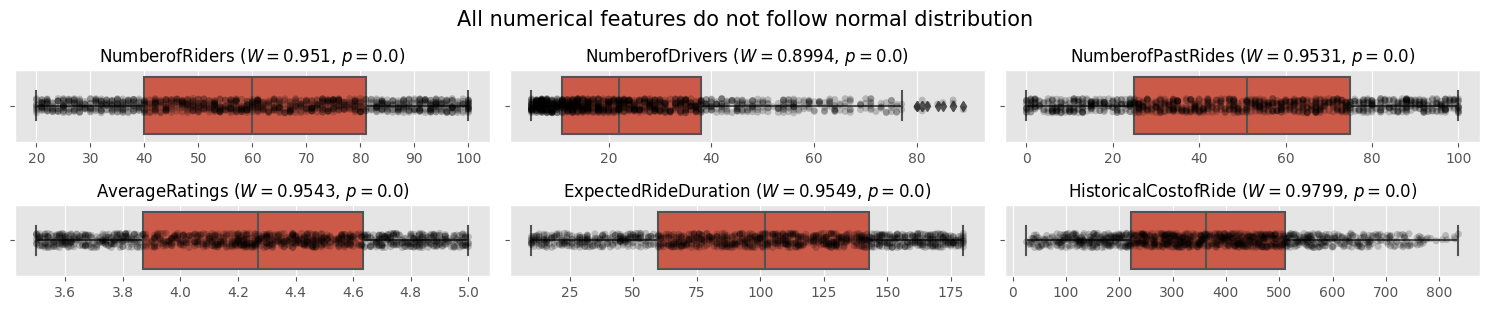

In [72]:
# compute SW test
shapiro_results = df_numeric.apply(lambda col: shapiro(col))
stats_df = pd.DataFrame({
    'column': df_numeric.columns,
    'sw_statistic': df_numeric.apply(lambda col: shapiro(col)[0]).values.round(4),
    'sw_pvalues': df_numeric.apply(lambda col: shapiro(col)[1]).values.round(4)
})

# display boxplots
plt.figure(figsize=(15, 7))
for i, col in enumerate(df_numeric.columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(x=df[col])
    sns.stripplot(x=df[col], color='k', alpha=0.2, jitter=True)
    # locate H stat and p-val
    row = stats_df[stats_df['column'] == col]
    statistic = row['sw_statistic'].values[0]
    p_value = row['sw_pvalues'].values[0]
    plt.title(f'{col} ($W = {statistic}$, $p = {p_value}$)', size=12)
    plt.xlabel(None)
plt.suptitle('All numerical features do not follow normal distribution', size=15)
plt.tight_layout()
plt.show()

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

### **2.3 Outlier detection**
Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

In [73]:
# create function to detect outliers using IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"The number of outliers in '{column}' is {len(outliers)} or {(len(outliers)/len(df)*100):.2f}% of the total data ({len(df)} rows).")

In [74]:
# apply function to detect outliers
for i in df_numeric:
    detect_outliers(df, i)

The number of outliers in 'NumberofRiders' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'NumberofDrivers' is 10 or 1.00% of the total data (1000 rows).
The number of outliers in 'NumberofPastRides' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'AverageRatings' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'ExpectedRideDuration' is 0 or 0.00% of the total data (1000 rows).
The number of outliers in 'HistoricalCostofRide' is 0 or 0.00% of the total data (1000 rows).


**Note**: treatment using robust scaling

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

<h1 style='text-align:center; color:orange; font-weight:bold'>---END---</h1>

___